In [1]:
import numpy as np
import matplotlib.pyplot as plt
from information import ITPC

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 600
random_state = 200
X, y = make_blobs(n_samples=n_samples, centers=3, random_state=random_state, cluster_std=1)

# Incorrect number of clusters
n = 25
clust = ITPC(n_clusters=3, affinity='nearest_neighbors', n_neighbors = n, random_state=random_state)
labels = clust.fit_predict(X);
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title(str(n));
plt.show()

<600x600 sparse matrix of type '<class 'numpy.float64'>'
	with 18650 stored elements in Compressed Sparse Row format>

Iteration  1


/home/kirill/Downloads/information.py:239: RuntimeWarning: divide by zero encountered in log2
  P_log_1 = np.log2(P_log_1)
/home/kirill/Downloads/information.py:247: RuntimeWarning: divide by zero encountered in log2
  P_log_2 = np.log2(P_log_2)


360
Iteration  2
66
Iteration  3
46
Iteration  4
51
Iteration  5
20
Iteration  6
7
Iteration  7
2
Iteration  8
0


<Figure size 1200x1200 with 1 Axes>

Iteration  1
194
Iteration  2
1
Iteration  3
0


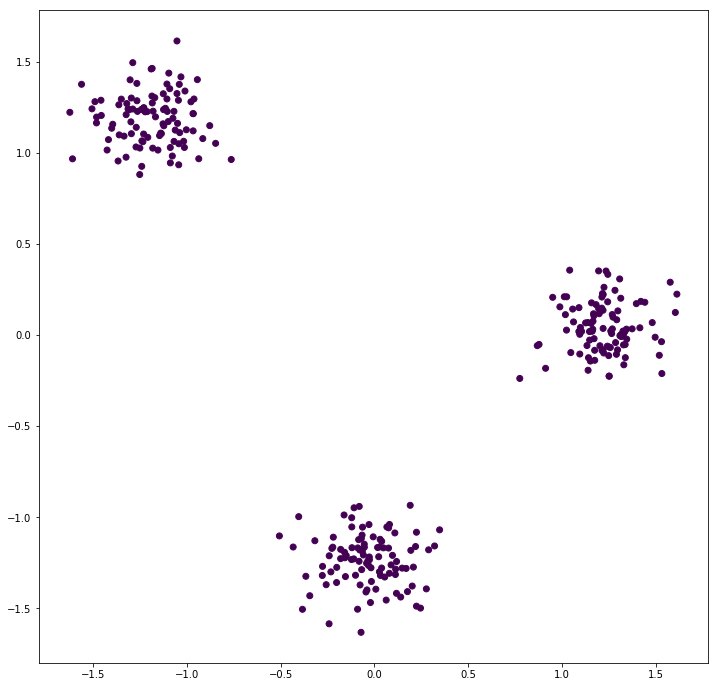

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from information import ITPC

from sklearn.datasets import make_blobs
np.random.seed(0)

plt.figure(figsize=(12, 12))

n_samples = 300
random_state = 200
X, y  = make_blobs(n_samples=n_samples, random_state=200, cluster_std=0.5)
X = StandardScaler().fit_transform(X)
# Incorrect number of clusters
clust = ITPC(n_clusters=3, gamma=5, random_state=0)
clust.fit(X);
plt.scatter(X[:, 0], X[:, 1], c=clust.labels_)
plt.show()

gamma =  10
gamma =  20
gamma =  3
gamma =  7
gamma =  5
gamma =  30


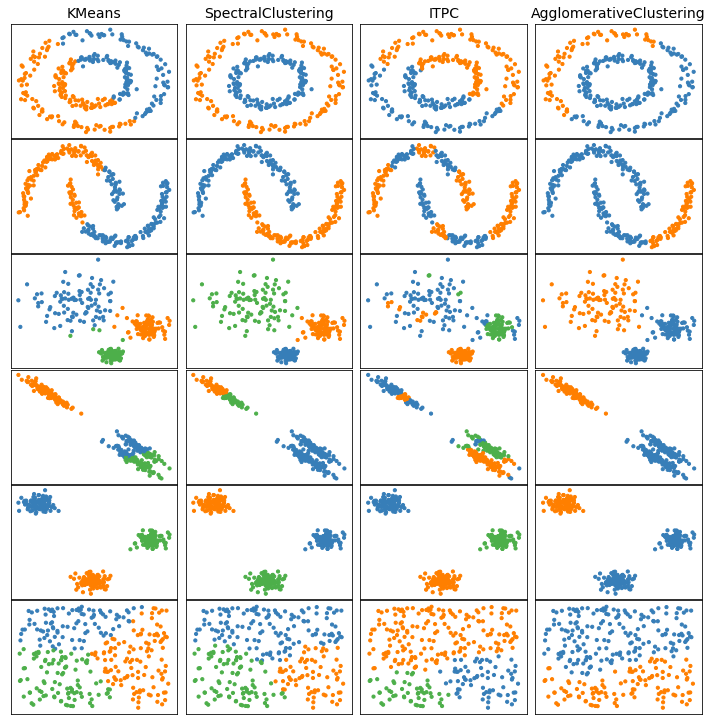

In [71]:
# the modified code from sklearn


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============

n_samples = 300
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=200, cluster_std=0.5)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropically distributed data
random_state = 200
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(4 * 2 + 2, 10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    two_means = cluster.KMeans(n_clusters=params['n_clusters'])
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    itpc = ITPC(n_clusters=params['n_clusters'], gamma = 5, random_state=0, verbose=False)
    
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    ward_linkage = cluster.AgglomerativeClustering(connectivity=connectivity)

    clustering_algorithms = (
        ('KMeans', two_means),
        ('SpectralClustering', spectral),
        ('ITPC', itpc),
        ('AgglomerativeClustering', ward_linkage),
    )
    
    gammas = [10, 20, 3, 7, 5, 30]
    
    for name, algorithm in clustering_algorithms:
        if algorithm == itpc:
#            print('gamma = ', gammas[i_dataset])
            algorithm.set_params(gamma = gammas[i_dataset])
        algorithm.fit(X)
    
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()